# Transformer based Dialogue Model on Google  TaskMaster-2 DataSet

Follow on Github : https://github.com/shahid-kh/ChatBot_Transformer


Follow on Linkedin: http://linkedin.com/in/shahid-khan-3abab5193


This code is inspired from official Tutorial of tensorflow:
https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html

I extended this work to use different dataset called Google Taskmaster-2 to see interesting results on General chats as assistant for various tasks of daily routine eg. Food ordering,Flight booking etc.

# Mount your Drive for DataSet Loading

In [1]:
from google.colab import drive
drive.mount("/mydrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /mydrive


#Necessary imports

In [2]:
import json
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

     |████████████████████████████████| 2.3MB 3.4MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


#Configuring TPU Strategy
Dont forget to change runtime type to TPU before running this Colab

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: grpc://10.123.240.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.123.240.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


# Reading Dataset From Google Drive

Take care of file paths ,where your dataset is stored.adjust accordingly

In [7]:
filenames=[]
filepaths=[]
data_list=[]
file_init_path='/mydrive/My Drive/ChatBot_Trnsfrmer_Taskmaster2/DataSet/'
filenames=os.listdir('/mydrive/My Drive/ChatBot_Trnsfrmer_Taskmaster2/DataSet')

for file in filenames:
  path=file_init_path+file
  filepaths.append(path)
  
for file in filepaths:
  with open(file) as f:
    data=json.load(f)
    data_list.append(data)

# PreProcessing Data and Extracting Conversations 

For detailed data understandin,go to Google Research page
https://github.com/google-research-datasets/Taskmaster/tree/master/TM-2-2020/data

In [8]:
conversation=[]
for data in data_list:

  for line in data:
    conversation.append(line['utterances'])

print(len(conversation))



17304


In [9]:
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence


#Separating data into Assistant and USER Sections.
Question is asked by user and answer is given by assistant

In [10]:
USER=[]
BOT=[]
def add_text(speaker,text):
  if (speaker=="USER"):
    USER.append(preprocess_sentence(text))
  elif (speaker=="ASSISTANT"):
    BOT.append(preprocess_sentence(text))
  else:
    print("Error")

In [11]:
def load_QA():
  last_speaker="None"
  current_speaker="None"
  temp_text=""
  for segment in conversation:
    for p in segment:
      current_speaker=p['speaker']
      if (last_speaker=="None"):
        temp_text=temp_text+p['text']
      
      else:
        if (current_speaker==last_speaker):
          temp_text=temp_text+p['text']

        else:
          add_text(last_speaker,temp_text)
          temp_text=""
          temp_text=temp_text+p['text']
    
      last_speaker=current_speaker

  return BOT,USER
      

    

    


In [12]:
questions,answers=load_QA()


# Configuring questions as USER and Answers as Assistant 

In [13]:


questions1=answers[0:142199]
answers1=questions[1:142200]

for i in range(142195,142199):
  print("Q: "+questions1[i])
  print("An: " +answers1[i])
print(len(questions1))
print(len(answers1))

Q: first class .
An: just one moment . i found one flight for , .
Q: that sounds good .
An: i have united flight leaving at am .
Q: and the returning flight ?
An: i have united flight leaving at am .
Q: alright , i d like to book that .
An: booking flight . was there anything else i can help you with ?
142199
142199


# Train Validation Split
For now, we will not be using validation data in training
to be updated in next version.

In [19]:
#train validation split ,TO be used later,Dont use fornow
question_val = questions1[-10000:]
answer_val = answers1[-10000:]
questions1 = questions1[:-10000]
answers1 = answers1[:-10000]

In [15]:

print('Sample question: {}'.format(questions1[120327]))
print('Sample answer: {}'.format(answers1[120327]))

Sample question: sure , i need it from sacramento to salt lake city . i d like to leave today and return in days .
Sample answer: do you want to leave the latest or earliest flight ?


# Tokenizing Data

In [20]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions1 + answers1, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2


In [22]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions1[20])))

Tokenized sample question: [28, 17, 2, 50, 1]


In [23]:
# Maximum sentence length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions1, answers1 = tokenize_and_filter(questions1,answers1)

In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions1)))

Vocab size: 8136
Number of samples: 125671


# Conversion of Data to tf.Data.Dataset pipeline format for easy data operations shuffling,buffering etc.

In [ ]:
BATCH_SIZE = 64  ##64,20000
BUFFER_SIZE = 40000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions1,
        'dec_inputs': answers1[:, :-1]
    },
    {
        'outputs': answers1[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


# Attention Codes

In [24]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

#Masks as per paper from Transfomers architecture

In [26]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

#Positional encoding as we are not using RNN/LSTMs.

In [28]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#Encoder

In [29]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#Decoder

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#Transformer 

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)
  
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
  

# Hyperparameters

In [34]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 6 #2,6
D_MODEL = 256
NUM_HEADS = 8  #8
UNITS = 512
DROPOUT = 0.1



#Loss Function,Accuracy and Custom learning rate scheduler
Feel free to experiment with learning rate 

In [37]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [39]:
import datetime
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)




#Building model with TPU strategy

In [40]:
with strategy.scope():
  model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)
  model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# Training

In [ ]:
EPOCHS =20

history=model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
   2/1964 [..............................] - ETA: 2:25 - loss: 0.9845 - accuracy: 0.1332WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


1964/1964 [==============================] - 139s 71ms/step - loss: 0.8105 - accuracy: 0.1516
Epoch 2/20
1964/1964 [==============================] - 137s 70ms/step - loss: 0.7440 - accuracy: 0.1587
Epoch 3/20
1964/1964 [==============================] - 140s 71ms/step - loss: 0.6919 - accuracy: 0.1654
Epoch 4/20
1964/1964 [==============================] - 141s 72ms/step - loss: 0.6569 - accuracy: 0.1700
Epoch 5/20
1964/1964 [==============================] - 140s 71ms/step - loss: 0.6313 - accuracy: 0.1734
Epoch 6/20
1964/1964 [==============================] - 144s 74ms/step - loss: 0.6107 - accuracy: 0.1764
Epoch 7/20
1964/1964 [==============================] - 140s 71ms/step - loss: 0.5944 - accuracy: 0.1786
Epoch 8/20
1964/1964 [==============================] - 141s 72ms/step - loss: 0.5800 - accuracy: 0.1807
Epoch 9/20
1964/1964 [==============================] - 141s 72ms/step - loss: 0.5671 - accuracy: 0.1826
Epoch 10/20
1964/1964 [==============================] - 142s 72ms

#Plotting Curves

In [ ]:
from matplotlib import pyplot as plt


In [ ]:
epoch_no=[i for i in range(1,21)]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


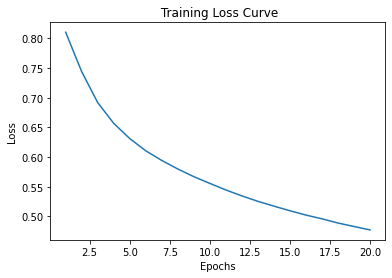

In [ ]:
#LOSS
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.set_title(' Training Loss Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.plot(epoch_no,history.history['loss'])
plt.savefig('/content/loss_chat.png')


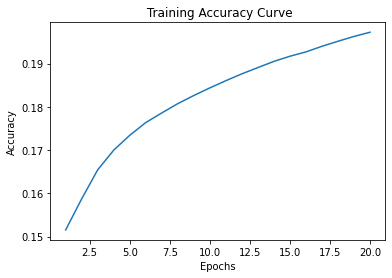

In [ ]:
#Accuracy
fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
ax1.set_title(' Training Accuracy Curve')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax1.plot(epoch_no,history.history['accuracy'])
plt.savefig('/content/accuracy_chat.png')

#Evaluation and Prediction

In [42]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

# Talk with your newly trained Friend

In [45]:
output = predict('i would like to order food')

Input: With Some cold Drink
Output: okay , i have a few options for you .


# Saving Tokenizer for later use

In [ ]:
#saving tokenizer
import pickle

# saving
with open('/mydrive/My Drive/ChatBot_Trnsfrmer_Taskmaster2/Pretrained_Weights/tokenizer_chatbot.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save weights as H5 so that next time you can use straightforward prediction

In [ ]:
model.save_weights('/mydrive/My Drive/ChatBot_Trnsfrmer_Taskmaster2/chat_trnsfrmer.h5', save_format='H5')

# Future Scope
We saw how  basic transformer even can be trained on dailogue tasks like this,though it doesnt give accuracy because we only trained for 20 epochs due to processing constraints. but this gives a fair idea how dialogue models are trained while also giving you the real taste of transformer archtectures.




# Happy Leaning ,Happy Coding

